# DS 3010 – Sleep Health & Lifestyle Project (Starter Notebook)
Team: **Nina De Grandis** & **Lucas Sorge**

## 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    r2_score, mean_squared_error, mean_absolute_error
)


## 2. Data Access

In [2]:
# Check if kagglehub is installed and available
try:
    import kagglehub
    HAS_KAGGLEHUB = True
except ImportError:
    HAS_KAGGLEHUB = False

import os

DATA_DIR = None
CSV_PATH = None

if HAS_KAGGLEHUB:
    path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")
    print("Dataset dir:", path)
    print("Files:", os.listdir(path))
    # Try to locate a CSV automatically
    csv_candidates = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
    if csv_candidates:
        CSV_PATH = os.path.join(path, csv_candidates[0])
        print("Using CSV:", CSV_PATH)
    else:
        print("No CSV file found in the KaggleHub directory.")
else:
    print("kagglehub not available; use option 2B and set CSV_PATH manually.")

Dataset dir: C:\Users\lucas\.cache\kagglehub\datasets\uom190346a\sleep-health-and-lifestyle-dataset\versions\2
Files: ['Sleep_health_and_lifestyle_dataset.csv']
Using CSV: C:\Users\lucas\.cache\kagglehub\datasets\uom190346a\sleep-health-and-lifestyle-dataset\versions\2\Sleep_health_and_lifestyle_dataset.csv


## 3. Load Data

In [3]:
assert CSV_PATH is not None, "CSV_PATH is not set. Complete Section 2A or 2B first."
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## 4. Quick EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


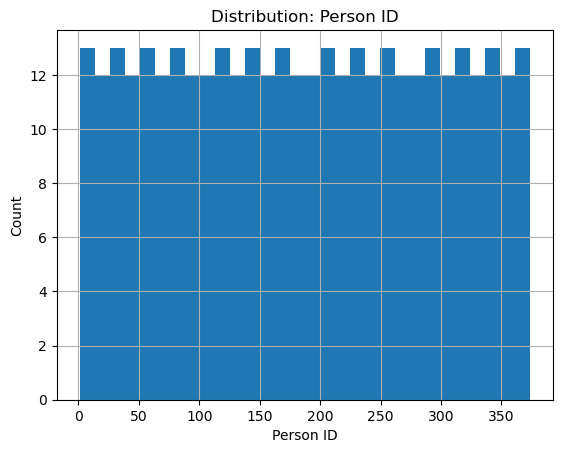

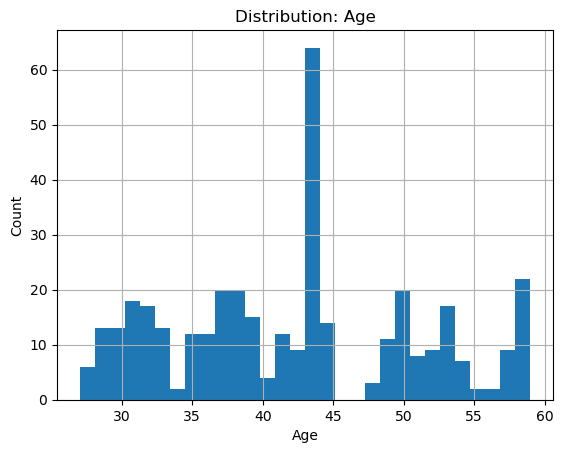

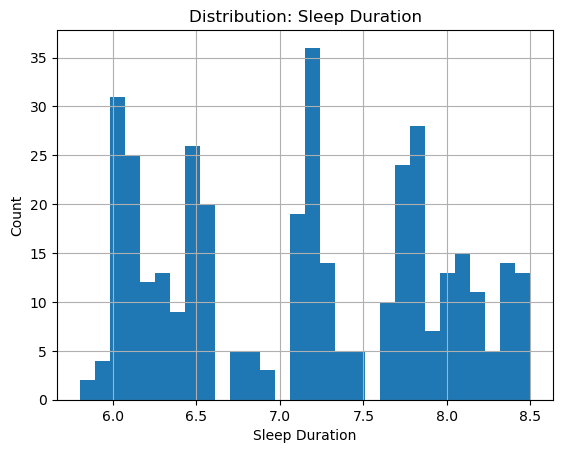

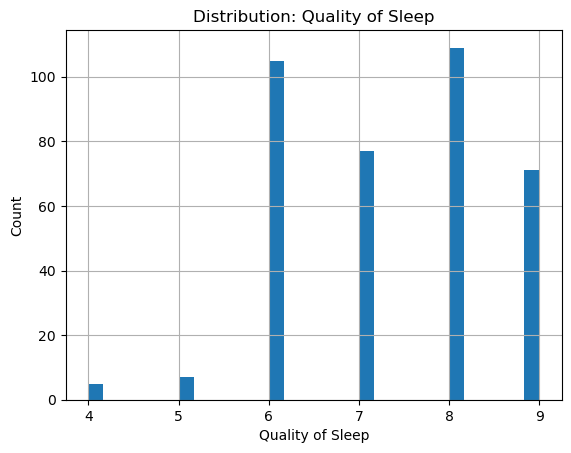

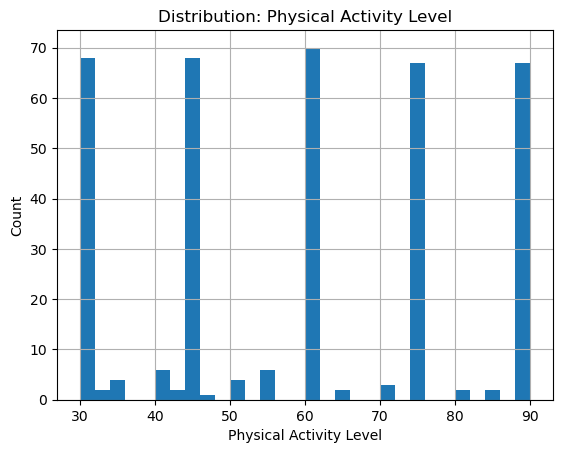

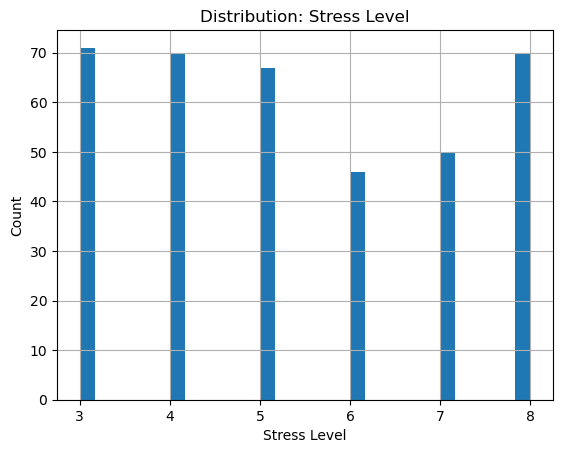

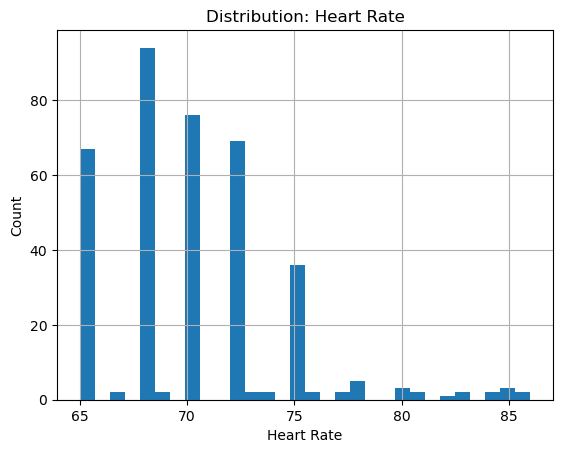

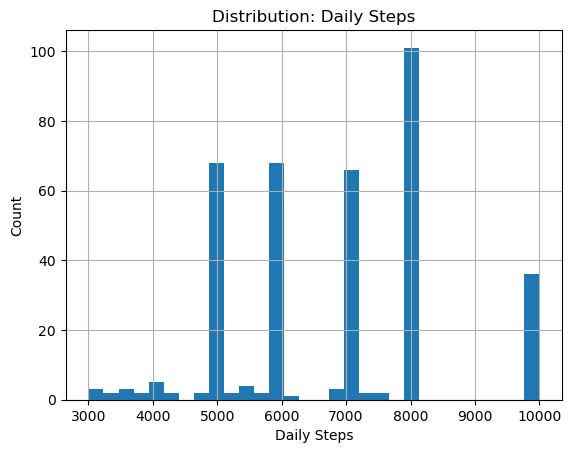

In [4]:
df.info()

df.describe(include="all").T

# Missing values overview
df.isnull().sum().sort_values(ascending=False)

# Simple histogram for numeric columns (one-by-one to avoid clutter)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## 5. Define Targets & Feature Matrix

In [5]:
# Classification target: Sleep Disorder
y_cls = df["Sleep Disorder"]
X_cls = df.drop(columns=["Sleep Disorder"])

# Regression target: Quality of Sleep
y_reg = df["Quality of Sleep"]
X_reg = df.drop(columns=["Quality of Sleep"])

# Identify numeric & categorical columns from the classification set
num_cols = X_cls.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_cls.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure']


## 6. Preprocessing Pipelines

In [6]:
# Numeric: impute median + scale
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute most_frequent + one-hot
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ]
)

## 7. Train/Test Split

In [7]:
# Make clean copies of X/y for both tasks, removing NaNs only from targets
# Classification
mask_cls = df["Sleep Disorder"].notna()
X_cls = df.loc[mask_cls].drop(columns=["Sleep Disorder"])
y_cls = df.loc[mask_cls, "Sleep Disorder"]

# Regression
mask_reg = df["Quality of Sleep"].notna()
X_reg = df.loc[mask_reg].drop(columns=["Quality of Sleep"])
y_reg = df.loc[mask_reg, "Quality of Sleep"]

print("Target NaNs removed ->",
      "cls:", (~mask_cls).sum(), "rows dropped |",
      "reg:", (~mask_reg).sum(), "rows dropped")

# sanity check class balance
print("Class distribution:\n", y_cls.value_counts(dropna=False))

# If each class has at least 2 samples, we can stratify safely
from sklearn.model_selection import train_test_split

ok_to_stratify = (y_cls.value_counts().min() >= 2)
strat = y_cls if ok_to_stratify else None

Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=strat
)

Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Classification shapes:", Xtr_c.shape, Xte_c.shape, ytr_c.shape, yte_c.shape)
print("Regression shapes:", Xtr_r.shape, Xte_r.shape, ytr_r.shape, yte_r.shape)

Target NaNs removed -> cls: 219 rows dropped | reg: 0 rows dropped
Class distribution:
 Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64
Classification shapes: (124, 12) (31, 12) (124,) (31,)
Regression shapes: (299, 12) (75, 12) (299,) (75,)


## 8. Baseline Models

### 8.1 Logistic Regression – Sleep Disorder (Classification)

In [8]:
log_pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])
log_pipe.fit(Xtr_c, ytr_c)
yp_c = log_pipe.predict(Xte_c)

print("Accuracy:", accuracy_score(yte_c, yp_c))
print("\nClassification Report\n", classification_report(yte_c, yp_c))
print("\nConfusion Matrix\n", confusion_matrix(yte_c, yp_c))

Accuracy: 0.8709677419354839

Classification Report
               precision    recall  f1-score   support

    Insomnia       0.87      0.87      0.87        15
 Sleep Apnea       0.88      0.88      0.88        16

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31


Confusion Matrix
 [[13  2]
 [ 2 14]]


### 8.2 Linear Regression – Quality of Sleep (Regression)

R^2: 0.9349510453169828
RMSE: 0.3132639439308744
MAE: 0.0829859598354075


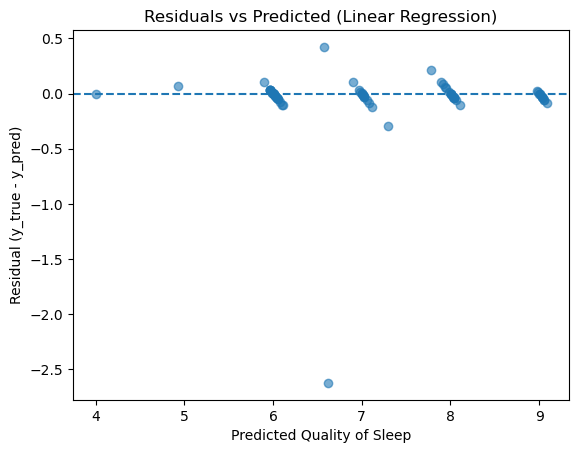

In [9]:
# Safety: drop obvious identifiers if still present in the split frames
for id_like in ["Person ID", "PersonID", "ID"]:
    if id_like in Xtr_r.columns:
        Xtr_r = Xtr_r.drop(columns=[id_like])
        Xte_r = Xte_r.drop(columns=[id_like])

# Build a regression preprocessor that AUTO-selects columns from whatever X you pass
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_reg = ColumnTransformer([
    ("num", num_pipe, selector(dtype_include=np.number)),
    ("cat", cat_pipe, selector(dtype_exclude=np.number)),
])

lin_pipe = Pipeline([
    ("pre", preprocess_reg),
    ("reg", LinearRegression())
])

lin_pipe.fit(Xtr_r, ytr_r)
yp_r = lin_pipe.predict(Xte_r)

print("R^2:", r2_score(yte_r, yp_r))
rmse = np.sqrt(mean_squared_error(yte_r, yp_r))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(yte_r, yp_r))

# quick residuals sanity check for the report
import matplotlib.pyplot as plt
resid = yte_r - yp_r
plt.figure()
plt.scatter(yp_r, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Quality of Sleep")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()

## 9. Model Insight: Coefficients

In [10]:
# Recover feature names after preprocessing (for interpretability)
ohe = log_pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

if hasattr(log_pipe.named_steps["clf"], "coef_"):
    coefs = log_pipe.named_steps["clf"].coef_
    # For multinomial, this is (n_classes, n_features). We'll display per class.
    if coefs.ndim == 2 and coefs.shape[0] > 1:
        for i, row in enumerate(coefs):
            top_idx = np.argsort(np.abs(row))[::-1][:15]
            print(f"Top 15 coefficients for class {i}:")
            for idx in top_idx:
                print(f"{feature_names[idx]:40s} {row[idx]: .4f}")
            print("-"*60)
    else:
        row = coefs.ravel()
        top_idx = np.argsort(np.abs(row))[::-1][:20]
        print("Top 20 coefficients (binary or OvR view):")
        for idx in top_idx:
            print(f"{feature_names[idx]:40s} {row[idx]: .4f}")
else:
    print("Classifier does not expose coefficients.")

Top 20 coefficients (binary or OvR view):
Blood Pressure_140/95                     1.2998
Occupation_Nurse                          1.1398
Heart Rate                                1.0833
Sleep Duration                            1.0093
Blood Pressure_135/90                    -0.8925
Daily Steps                               0.8401
Blood Pressure_130/85                    -0.7587
Occupation_Salesperson                   -0.7164
Occupation_Accountant                    -0.6739
Blood Pressure_120/80                     0.6423
Occupation_Engineer                      -0.5553
Person ID                                -0.5183
Occupation_Sales Representative           0.4807
Blood Pressure_142/92                    -0.4626
Gender_Female                             0.4205
Gender_Male                              -0.4198
Blood Pressure_129/84                     0.4051
Blood Pressure_115/75                    -0.3581
Blood Pressure_130/86                    -0.3274
Occupation_Software Enginee

## 10. Save Artifacts (Pipelines & Metrics)

In [11]:
from pathlib import Path
import json
import joblib

out_dir = Path("artifacts")
out_dir.mkdir(exist_ok=True)

# Save pipelines
joblib.dump(log_pipe, out_dir / "logistic_sleep_disorder_pipeline.joblib")
joblib.dump(lin_pipe, out_dir / "linear_sleep_quality_pipeline.joblib")

# Save quick metrics
metrics = {
    "classification": {
        "accuracy": float(accuracy_score(yte_c, yp_c))
    },
    "regression": {
        "r2": float(r2_score(yte_r, yp_r)),
        "rmse": float(rmse),
        "mae": float(mean_absolute_error(yte_r, yp_r))
    }
}
with open(out_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:", list(out_dir.iterdir()))

Saved: [WindowsPath('artifacts/linear_sleep_quality_pipeline.joblib'), WindowsPath('artifacts/logistic_sleep_disorder_pipeline.joblib'), WindowsPath('artifacts/metrics.json')]
